# Analisi di Clustering sul Dataset di Transazioni con Frodi

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import json

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")


In [ ]:
trans_final = pd.read_pickle('./trans_final.pkl')
trans_final.info()


In [ ]:
#eliminazione righe in cui non si ha info sulla frode
trans_final.dropna(subset=['fraud'], inplace=True)
#trasformazione delle colonne categoriche in numeriche
le = LabelEncoder()
for column in ['mcc_description', 'merchant_city', 'merchant_state','use_chip','card_brand','card_type','gender','has_chip']:
    trans_final[column] = le.fit_transform(trans_final[column])

to_drop = ['id_trans','client_id_trans','card_id','client_id_card','id','retirement_age','address','expires','day','time']
trans_final = trans_final.drop(to_drop, axis=1)

trans_final = trans_final.apply(pd.to_numeric, downcast='integer') 
trans_final = trans_final.apply(pd.to_numeric, downcast='float') 



In [ ]:
trans_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8914963 entries, 0 to 13305912
Data columns (total 26 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   amount                 float32
 1   use_chip               int8   
 2   merchant_id            float32
 3   merchant_city          int16  
 4   merchant_state         int16  
 5   fraud                  int8   
 6   card_brand             int8   
 7   card_type              int8   
 8   has_chip               int8   
 9   num_cards_issued       int8   
 10  credit_limit           float32
 11  acct_open_date         float64
 12  year_pin_last_changed  int16  
 13  card_valid_month       int16  
 14  current_age            int8   
 15  birth_year             int16  
 16  gender                 int8   
 17  latitude               float32
 18  longitude              float32
 19  per_capita_income      float32
 20  yearly_income          float32
 21  total_debt             float32
 22  credit_score          

cluster bidimensionale considerando current_age e yearly_income per vedere come il reddito varia con l'età.

In [ ]:
data = trans_final[['current_age', 'yearly_income']].dropna()  # Rimuovi eventuali NaN
x = data.values

# Normalizza i dati 
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

elbow method per scegliere k migliore

  File "C:\Users\sarab\AppData\Roaming\Python\Python313\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Program Files\Python313\Lib\subprocess.py", line 556, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Program Files\Python313\Lib\subprocess.py", line 1038, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        start_new_session, process_group)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Program Files\

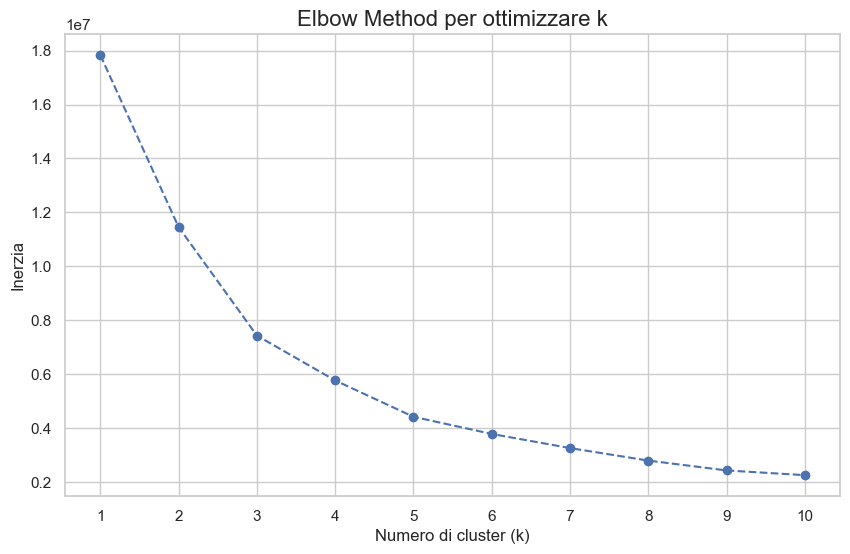

In [ ]:
# Calcola l'inerzia per k da 1 a 10
inertia = []
for k in range(1, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(x_scaled)
    inertia.append(km.inertia_)

# Plot dell'Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.xlabel('Numero di cluster (k)', fontsize=12)
plt.ylabel('Inerzia', fontsize=12)
plt.title('Elbow Method per ottimizzare k', fontsize=16)
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

k-means

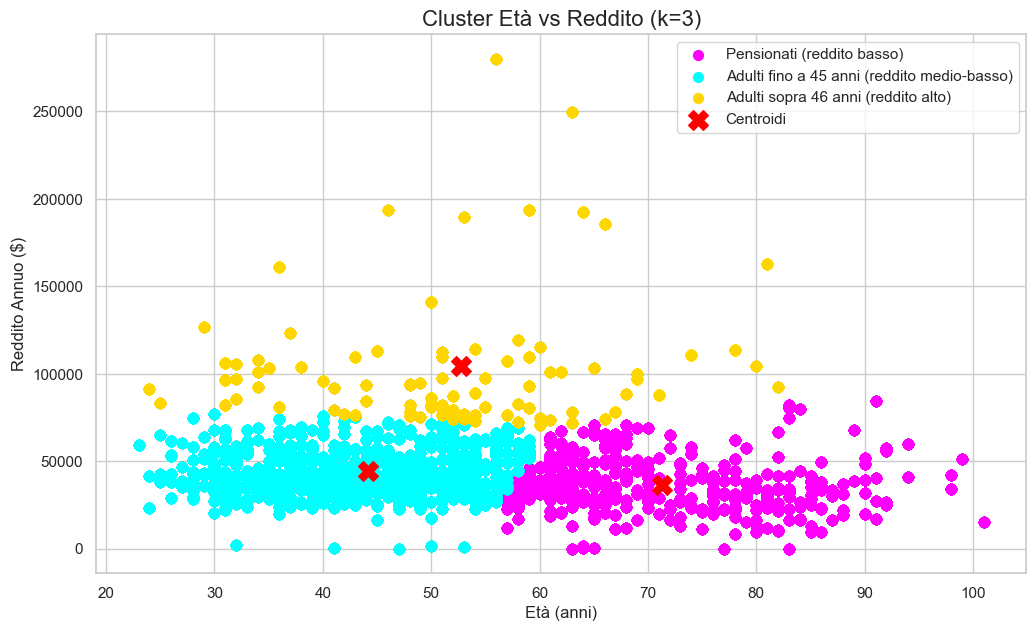

In [ ]:
# Esegui K-means con k=4
km = KMeans(n_clusters=3, random_state=42)
y_means = km.fit_predict(x_scaled)

# Aggiungi i cluster ai dati originali
data['cluster'] = y_means
cluster_centers = scaler.inverse_transform(km.cluster_centers_)

# Plot dei cluster
plt.figure(figsize=(12, 7))
colors = ['magenta', 'cyan', 'gold', 'lightgreen']
labels = {
    0:"Pensionati (reddito basso)",
    1:"Adulti fino a 45 anni (reddito medio-basso)",
    2:"Adulti sopra 46 anni (reddito alto)",
    3:"Senior sopra i 60 (reddito molto alto)"
}

for cluster_num in range(3):
    mask = (y_means == cluster_num)
    plt.scatter(
        x[mask, 0], x[mask, 1], 
        s=50, c=colors[cluster_num], 
        label=labels[cluster_num]
    )

plt.scatter(
    cluster_centers[:, 0], cluster_centers[:, 1], 
    s=200, c='red', marker='X', label='Centroidi'
)

plt.title('Cluster Età vs Reddito (k=3)', fontsize=16)
plt.xlabel('Età (anni)', fontsize=12)
plt.ylabel('Reddito Annuo ($)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

prova de siloutte non riuscita ma ripartiremo da qua ahah

In [ ]:
plt.figure(figsize=(15,8))

silhouette_avg = silhouette_score(x_scaled, km.labels_)
sample_values = silhouette_samples(x_scaled, km.labels_)
n_clusters = 4
y_lower = 10
for i in range(n_clusters):
    ith_values = sample_values[labels == i]
    ith_values.sort()
    
    size = ith_values.shape[0]
    y_upper = y_lower + size
    
    color = plt.cm.Spectral(float(i)/n_clusters)
    plt.fill_betweenx(np.arange(y_lower,y_upper),
                    0, ith_values,
                    facecolor=color, edgecolor=color, alpha=0.7)
    
    plt.text(-0.05, y_lower + 0.5*size, str(i))
    y_lower = y_upper + 10

plt.title(f"Silhouette Plot (Avg: {silhouette_avg:.2f})")
plt.xlabel("Silhouette Coefficient")
plt.ylabel("Cluster")
plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.show()

KeyboardInterrupt: 

<Figure size 1500x800 with 0 Axes>

per capire bene cosa c'è dentro ogni centro

In [ ]:
print(data.groupby('cluster').mean())

         current_age  yearly_income
cluster                            
0          71.472120   34972.996094
1          43.300018   40843.203125
2          52.158914   76435.015625
3          59.427227  193122.250000


clustering gerarchico

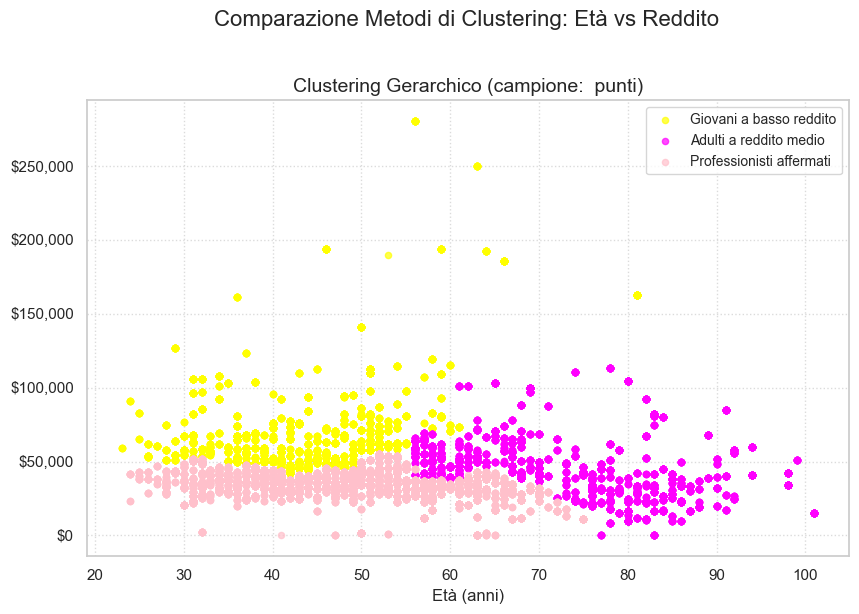

In [ ]:
# 2. Clustering Gerarchico sul campione
hc = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
sample_size = 20_000
np.random.seed(42)
idx = np.random.choice(len(x_scaled), sample_size, replace=False)
x_sample = x_scaled[idx]
x_sample_original = x[idx] 
y_hc = hc.fit_predict(x_sample)

# --- Subplot 2: Clustering Gerarchico (sul campione) ---
plt.figure(figsize=(8, 6))
colors_hc = ['yellow', 'magenta', 'pink', 'cyan']
labels_hc = {
    0: "Giovani a basso reddito",
    1: "Adulti a reddito medio",
    2: "Professionisti affermati",
    3: "Senior benestanti"
}

for i in range(3):
    plt.scatter(
        x_sample_original[y_hc == i, 0], x_sample_original[y_hc == i, 1],
        s=20, c=colors_hc[i],
        alpha=0.7,
        label=labels_hc[i]
    )
plt.title(f'Clustering Gerarchico (campione:  punti)', fontsize=14)
plt.xlabel('Età (anni)', fontsize=12)
plt.gca().yaxis.set_ticklabels([])
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.7)

plt.suptitle('Comparazione Metodi di Clustering: Età vs Reddito', fontsize=16, y=1.02)
plt.tight_layout()

# Formattazione assi Y in dollari
for ax in plt.gcf().axes:
    ax.yaxis.set_major_formatter('${x:,.0f}')

plt.show()

clustering bidimensionale con credit_limit e amount

metodo del gomitolo

In [ ]:
# Seleziona solo le colonne necessarie e rimuove i valori mancanti
df_kmeans = trans_final[['credit_limit', 'amount']].dropna()

# Step 2: Standardizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_kmeans)

# Step 3: Metodo del gomito per trovare il k ottimale
distortions = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    distortions.append(kmeans.inertia_)

# Step 4: Visualizzazione
plt.figure(figsize=(15, 5))
plt.plot(K, distortions, 'bo-')
plt.title('Metodo del Gomito (Elbow Method)', fontsize=20)
plt.xlabel('Numero di cluster (k)')
plt.ylabel('Distorsione (Inertia)')
plt.grid(True)
plt.show()

k-means

In [ ]:

#cluster bidimensionale con kmeans

# Applica KMeans (es. con 4 cluster)
kmeans = KMeans(n_clusters=4, init='random', max_iter=300, n_init=10, random_state=0)
y_means = kmeans.fit_predict(df_kmeans)

# Plot dei cluster con colori e etichette personalizzate
plt.figure(figsize=(15,8))
plt.scatter(df_kmeans.values[y_means == 0, 0], df_kmeans.values[y_means == 0, 1], 
            s=100, c='yellow', label='Basso limite, bassa spesa')
plt.scatter(df_kmeans.values[y_means == 1, 0], df_kmeans.values[y_means == 1, 1], 
            s=100, c='magenta', label='Basso limite, alta spesa')
plt.scatter(df_kmeans.values[y_means == 2, 0], df_kmeans.values[y_means == 2, 1], 
            s=100, c='cyan', label='Alto limite, alta spesa')
plt.scatter(df_kmeans.values[y_means == 3, 0], df_kmeans.values[y_means == 3, 1], 
            s=100, c='pink', label='Alto limite, bassa spesa')

# Centroidi
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 
            s=200, c='blue', label='Centroidi')

# Titoli e legenda
plt.title('KMeans Clustering: Limite di Credito vs Spesa', fontsize=20)
plt.xlabel('Limite di credito (credit_limit)')
plt.ylabel('Importo speso (amount)')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'trans_final' is not defined

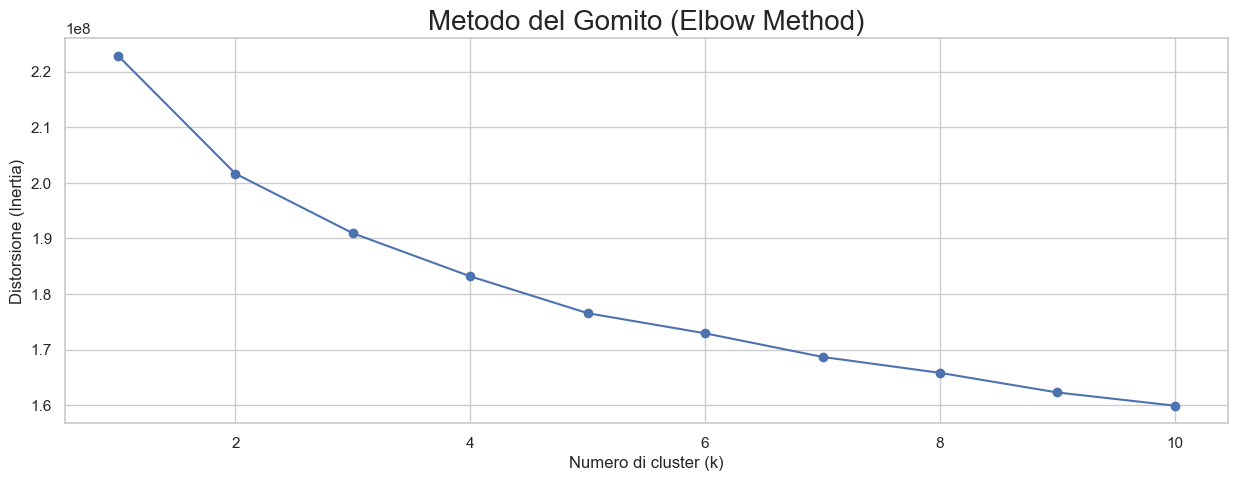

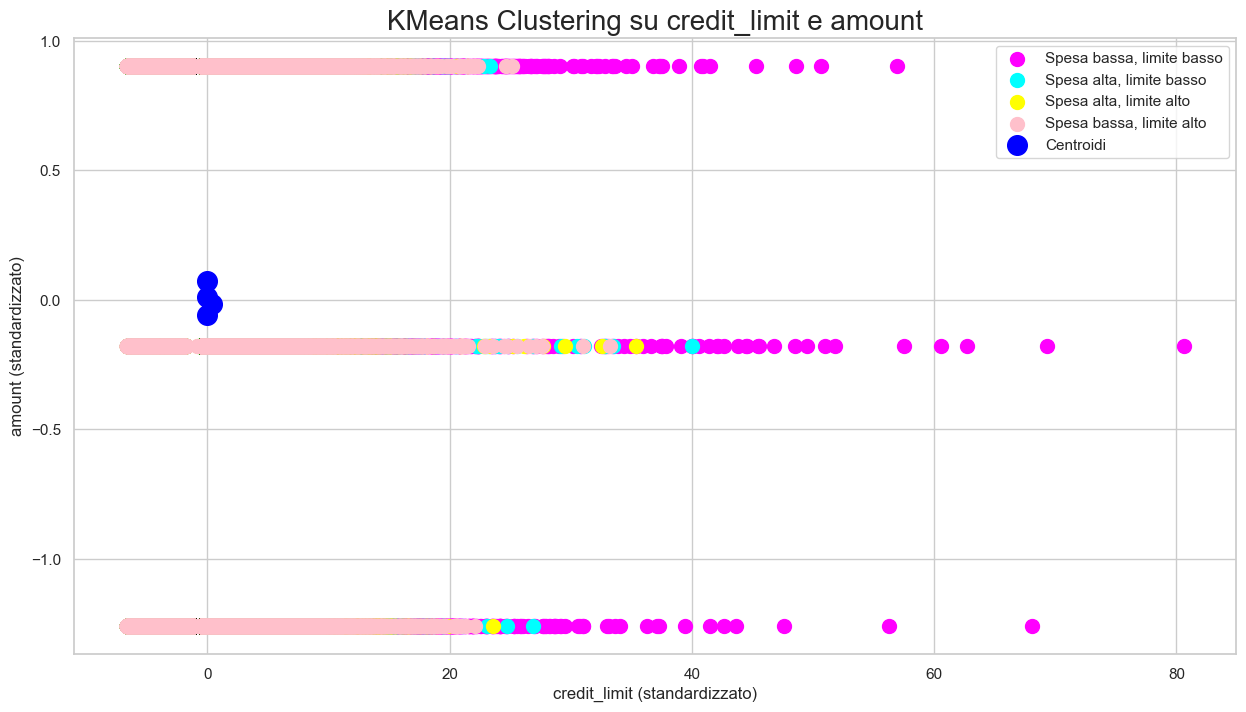

In [ ]:
# Supponiamo che k = 4
k = 4

# Clustering finale
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
y_kmeans = kmeans.fit_predict(X_scaled)

# Visualizzazione dei cluster
plt.figure(figsize=(15, 8))
colors = ['magenta', 'cyan', 'yellow', 'pink']
labels = ['Spesa bassa, limite basso', 'Spesa alta, limite basso', 'Spesa alta, limite alto', 'Spesa bassa, limite alto']

for i in range(k):
    plt.scatter(X_scaled[y_kmeans == i, 0], X_scaled[y_kmeans == i, 1], 
                s=100, c=colors[i], label=labels[i])

# Centroidi
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            s=200, c='blue', label='Centroidi')

plt.title('KMeans Clustering su credit_limit e amount', fontsize=20)
plt.xlabel('credit_limit (standardizzato)')
plt.ylabel('amount (standardizzato)')
plt.legend()
plt.grid(True)
plt.show()
